# Analyse de besoins avec BERT

**Présentateur** :

TIMITE Abdoul - EQUADE

## Contexte

Le **CFPB** (Consumer Financial Protection Bureau) est une agence gouvernementale américaine qui a pour but de protéger les consommateurs des pratiques déloyales dont ils peuvent être victime de la part des institutions financières.

Chaque semaine, le **CFPB** recolte des centaines de réclamations et les envoie aux entreprises financières concernées afin d'obtenir une réponse pour les consommateurs. Ces réclamations viennent alimenter l'historique des réclamations et cette base de données (**Consumer Complaint Database**) est gérée et mise à dipsosition par le Bureau via son site internet.

Nous voulons, à partir d'un echantillon de cette base de données, prédire le problème associé à une réclamation à partir de sa description en utilisant le modèle BERT. L'objectif est de fournir un outil capable d'identifier rapidement et précisément les problèmes, améliorant ainsi la réactivité et la qualité du service client.

## Démarche

**Déroulé du projet**

1. Manipulation des données
* Importation
* Exploration
* Prétraitement


2. Analyse de sentiment

3. Classification avec BERT


**Les variables à considérer dans la base :**

Consumer complaint narrative = entrée

Issue = etiquette

## Mise en oeuvre

In [ ]:
!pip install sentence_transformers
!pip install gensim
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 26.3 MB/s eta 0:00:00


In [ ]:
import transformers
import torch
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torch.optim import AdamW
import numpy as np
import pandas as pd
import gdown
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import pandas as pd
import numpy as np
from scipy import spatial
import os
import matplotlib
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import English
import en_core_web_sm
import multiprocessing
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.cluster import contingency_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
import re
from sentence_transformers import SentenceTransformer

### 1. Manipulation des données

Nous passons par Google Drive pour importer la base de données.

In [ ]:
file_id = "1mqaJzAeyhxPF6YRzP6oNIPI3YcK-nZSP"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "base_reclamations.csv", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1mqaJzAeyhxPF6YRzP6oNIPI3YcK-nZSP
From (redirected): https://drive.google.com/uc?id=1mqaJzAeyhxPF6YRzP6oNIPI3YcK-nZSP&confirm=t&uuid=7806da24-fb53-43cd-aa13-bb4d68198506
To: /content/base_reclamations.csv
100%|██████████| 117M/117M [00:00<00:00, 203MB/s]


'base_reclamations.csv'

In [ ]:
# Importation de la base de données
reclamations = pd.read_csv("base_reclamations.csv")
reclamations.head(10)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,01/13/23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,Right now I am bothered! I have attempted to b...,NaN,"EQUIFAX, INC.",TX,78750,NaN,Consent provided,Web,01/13/23,Closed with explanation,Yes,NaN,6439929
1,08/23/23,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,Online disputes were filed with all 3 credit b...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TX,75217,NaN,Consent provided,Web,08/23/23,Closed with explanation,Yes,NaN,7438064
2,09/23/23,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,This is my NUMEROUS request that I have been a...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TX,77082,NaN,Consent provided,Web,09/23/23,Closed with non-monetary relief,Yes,NaN,7590175
3,06/25/23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with Fair Credit Reporting Act t...,NaN,"National Credit Adjusters, LLC",TX,XXXXX,NaN,Consent provided,Web,06/25/23,Closed with explanation,Yes,NaN,7164323
4,01/23/23,Checking or savings account,Checking account,Closing an account,Funds not received from closed account,Capital One sent my payment to a closed acct. ...,NaN,CAPITAL ONE FINANCIAL CORPORATION,TX,77070,NaN,Consent provided,Web,01/24/23,Closed with explanation,Yes,NaN,6474699
5,01/24/23,Checking or savings account,Checking account,Problem caused by your funds being low,Overdrafts and overdraft fees,When my account had enough funds I would get w...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,TX,77494,NaN,Consent provided,Web,01/24/23,Closed with explanation,Yes,NaN,6474563
6,09/18/23,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Their investigation did not fix an error on yo...,The existence of a derogatory rating on my acc...,NaN,JPMORGAN CHASE & CO.,TX,77379,NaN,Consent provided,Web,09/18/23,Closed with explanation,Yes,NaN,7568480
7,09/26/23,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,15 U.S. Code 6802 - Obligations with respect t...,NaN,"EQUIFAX, INC.",TX,XXXXX,NaN,Consent provided,Web,09/26/23,Closed with explanation,Yes,NaN,7601151
8,12/12/23,Credit reporting or other personal consumer re...,Credit reporting,Problem with a company's investigation into an...,Was not notified of investigation status or re...,"On XX/XX/23, I submitted disputes to XXXX, Equ...",NaN,"EQUIFAX, INC.",TX,75052,NaN,Consent provided,Web,12/12/23,Closed with non-monetary relief,Yes,NaN,7987938
9,10/03/22,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TX,765XX,NaN,Consent provided,Web,10/03/22,Closed with non-monetary relief,Yes,NaN,6045965


In [ ]:
# Dimension de la base de données
reclamations.shape

(89793, 18)

Notre base de données est donc composée de 89 793 réclamations et 18 variables décrivant ces réclamations.

In [ ]:
reclamations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89793 entries, 0 to 89792
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date received                 89793 non-null  object 
 1   Product                       89793 non-null  object 
 2   Sub-product                   89792 non-null  object 
 3   Issue                         89793 non-null  object 
 4   Sub-issue                     85515 non-null  object 
 5   Consumer complaint narrative  89793 non-null  object 
 6   Company public response       51325 non-null  object 
 7   Company                       89793 non-null  object 
 8   State                         89793 non-null  object 
 9   ZIP code                      89793 non-null  object 
 10  Tags                          9324 non-null   object 
 11  Consumer consent provided?    89793 non-null  object 
 12  Submitted via                 89793 non-null  object 
 13  D

Nous observons que la majorité de nos variables ont des observations complètes, notamment les variables **Consumer complaint narrative** et **Issue** qui nous inttèresse. On peut neanmmoins remmarquer que la variable **Consumer disputed?** n'est pas renseigné.

Les variables étant majoritairement textuelles, elles sont de type *object*.

<Axes: >

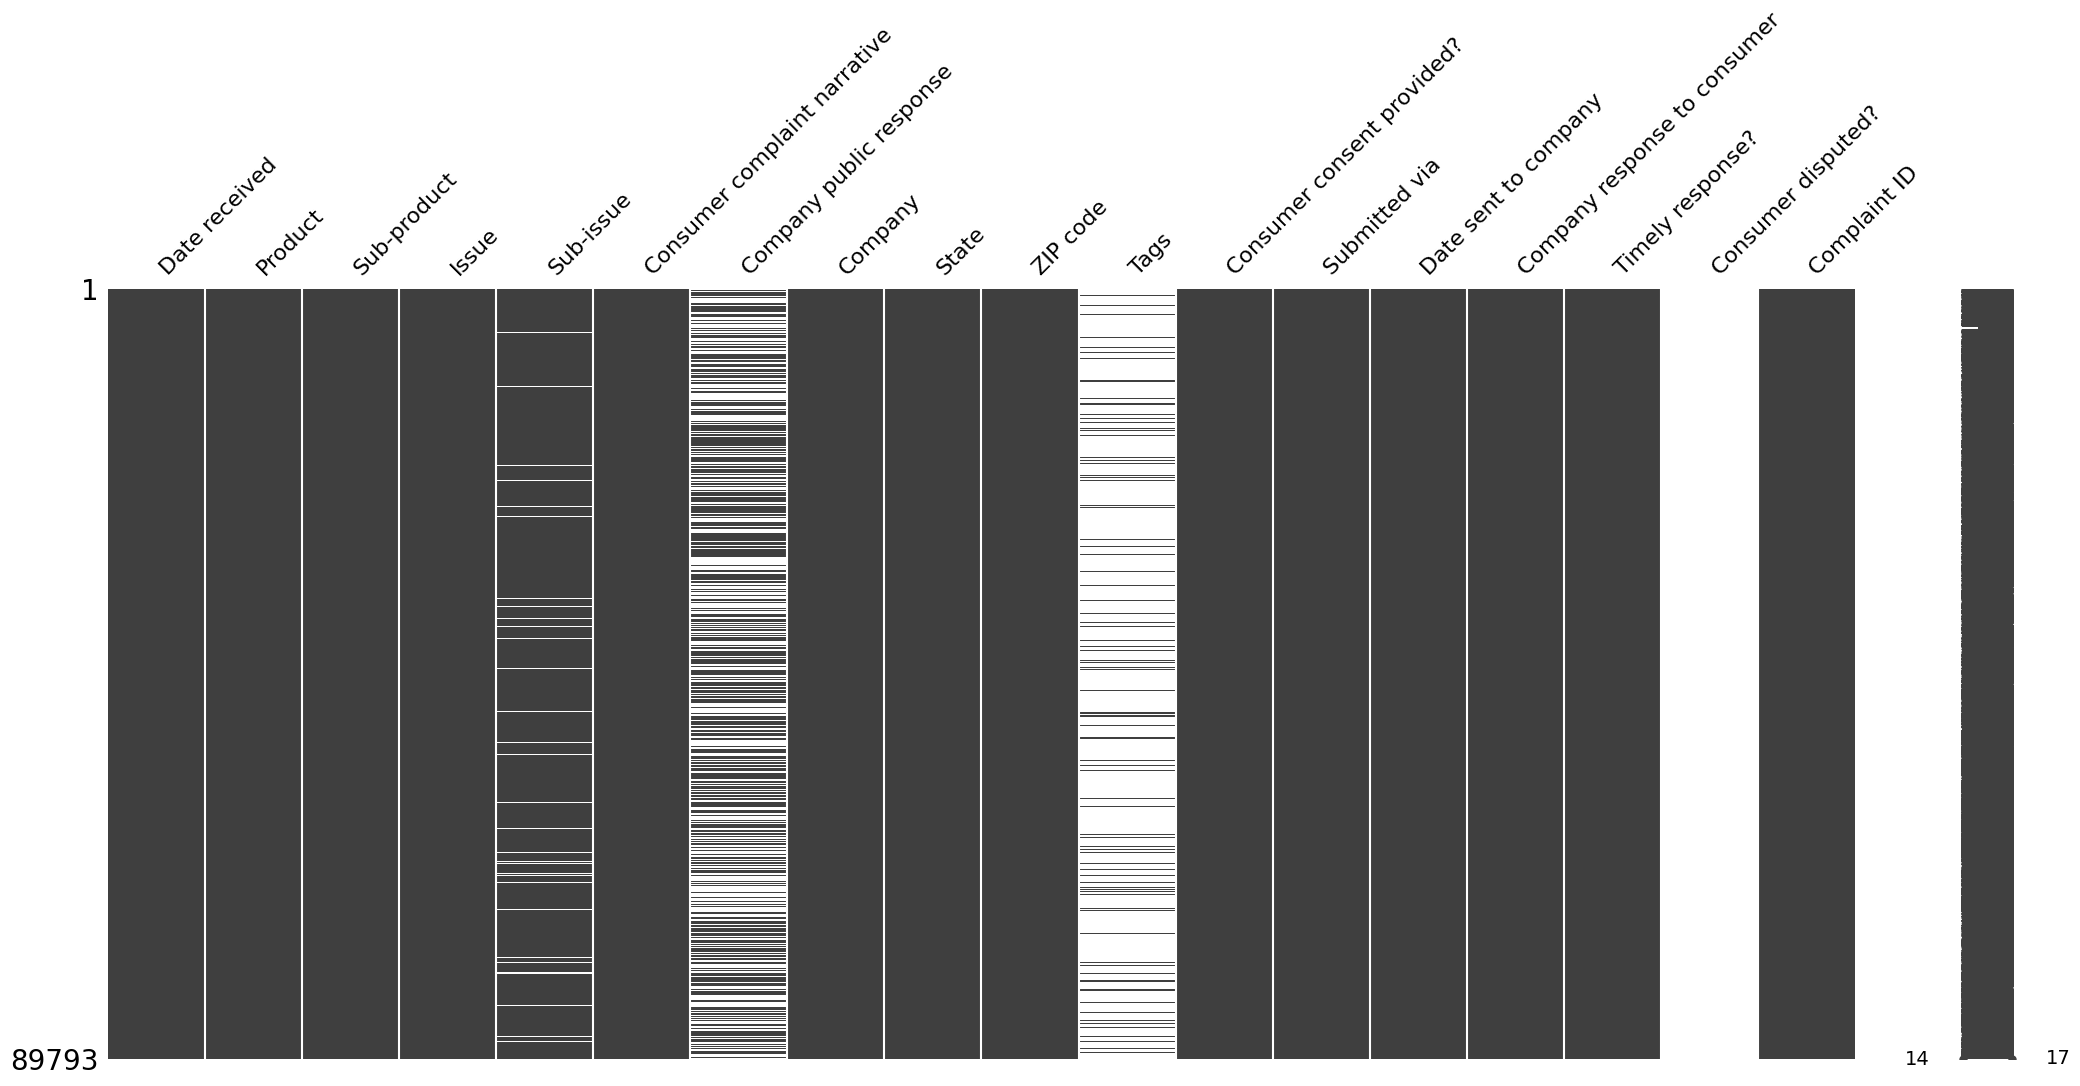

In [ ]:
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# Valeurs manquantes
msno.matrix(reclamations)

Cette représentation nous permet de mieux visualiser l'ampleur des valeurs manquantes, que nous avions déjà identifié plus haut.

Les variables comportant des variables manquantes sont :
* Consumer disputed?, qui n'est pas renseigné
* Tags
* Company public response
* Sub-issue

Il faut savoir qu'il n'est pas courant que les entreprises à qui sont adressées des réclamations envoient des reponses dites publiques (que tout le monde peut connaitre). Le plus souvent les réclamations se règle en privée, d'où le fait que la variable ***Company public response*** comporte beaucoup de valeurs manquantes.

In [ ]:
reclamations.nunique()

,0
Date received,725
Product,14
Sub-product,55
Issue,84
Sub-issue,195
Consumer complaint narrative,65885
Company public response,10
Company,1273
State,1
ZIP code,586


Nous remarquons que plusieurs variables ont des valeurs uniques. Cela n'est cependant pas anormal. En effet, nous avons sélectionner les données récoltées dans l'Etat du **TEXAS**, ce qui fait que la variable ***State*** n'a qu'une valeur unique qui est "**TEXAS**". De même pour les variables sur le consentement et le moyen d'envoi des réclamations (***Consumer consent provided?*** et ***Submitted via***) : ce sont seulement les réclamations envoyées via le site du CPFB, sur lequel le consentement a été donné de les publier, qui figurent dans l'historique des réclamations gérées par le CPFB.

In [ ]:
reclamations.duplicated().sum()/len(reclamations)*100

np.float64(0.0)

Notre jeu de données ne comporte pas de ligne dupliquées, ce qui est une bonne nouvelle.

In [ ]:
def plot_categorical(data: pd.DataFrame, x: str, n: int):
    """
    Diagramme de comptage pour une variable catégorielle avec Plotly

    Parameters:
    -----------
    data: DataFrame
        La base de données

    x: str
        La variable catégorielle à représenter

    n: int
        Taille de la police pour l'affichage des modalités
    """

    # Compter les occurrences de chaque catégorie
    counts = data[x].value_counts().reset_index()
    counts.columns = [x, 'count']

    # Créer le graphique à barres
    fig = go.Figure(data=[
        go.Bar(x=counts[x], y=counts['count'], marker_color='blue')
    ])

    # Mettre à jour la mise en page
    fig.update_layout(
        xaxis=dict(tickangle=-45),
        font=dict(size=n),
        xaxis_title=x,
        yaxis_title='Count'
    )

    # Afficher le graphique
    fig.show()

#Exemple d'utilisation avec un DataFrame `reclamations` et une colonne catégorielle "Issue"
plot_categorical(reclamations, "Issue", 7)


La variable **Issue** comportent plusieurs types de description du problème. Nous remarquons cependant que la majorité des réclamations porte sur un petit nombre de problèmes spécifiques. Regardons les de plus près :

In [ ]:
counts = reclamations['Issue'].value_counts()
top_counts = counts[:10]

if len(counts) > 10:
    other_count = counts[10:].sum()
    top_counts['Autres'] = other_count

# Création du graphique à secteurs avec Plotly
fig = go.Figure(data=[go.Pie(labels=top_counts.index, values=top_counts, hole=0.3)])

# Mise à jour de la mise en page du graphique
fig.update_layout(
    title_text='Répartition de la variable Issue',
    annotations=[dict(text='Issue', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

# Affichage du graphique
fig.show()

On note donc que les principales préoccupations des utilisateurs (***Incorrect information on your report*** et ***Improper use of your report***) dans notre base de données, représentant plus de 50% des cas de réclamation, sont liées aux **credit reports**. C'est un historique de l'état des finances des individus et peut affecter la capacité à obtenir un crédit, un emploi ou une assurance.

Nous avons sélectionné aléatoirement un sous-ensemble de 5000 lignes dans notre ensemble de données initial, qui contient au total 89783 lignes. Cette réduction de taille nous permettra de travailler plus efficacement avec notre ensemble de données tout en conservant une représentation significative de nos données pour nos analyses et nos expériences.

In [ ]:
data_reclamations = reclamations.sample(n=5000, random_state=42)
data_reclamations.reset_index(drop=True, inplace=True)

In [ ]:
# Les variables pertinentes
data_reclamations = data_reclamations[["Consumer complaint narrative","Issue"]]
data_reclamations.head(15)

,Consumer complaint narrative,Issue
0,In accordance with the Fair Credit Reporting a...,Improper use of your report
1,I believe I have been a victim of fraudulent a...,Incorrect information on your report
2,In accordance with the Fair Credit Reporting a...,Improper use of your report
3,15 USC 1681 Section 602 States I have the righ...,Improper use of your report
4,In accordance with the Fair Credit Reporting A...,Improper use of your report
5,XXXX in the name of Clarity Services is doing ...,Improper use of your report
6,I am XXXX XXXX and Im submitting this complain...,Problem with fraud alerts or security freezes
7,I was contacted by Citibank about 2 months ago...,Managing an account
8,On XX/XX/2022 sent a letter regarding inaccura...,Problem with a credit reporting company's inve...
9,This is my XXXX endeavor to tell you that I am...,Incorrect information on your report


Il est recommandé d'appliquer le nettoyage uniquement sur les variables d'entrées qui seront utilisée pour entrainer notre modèle. Par conséquent nous appliquerons le nettoyage sur les variables ***Consumer complaint narrative***, qui est la description de la réclamation, et ***Issue*** qui est le problème remonté dans la description et que nous utiliserons comme "Label" dans notre modèle.

In [ ]:
data_reclamations["Consumer complaint narrative"][3]

'15 USC 1681 Section 602 States I have the right to privacy.\n\n15 USC 1681 Section 604 A Section 2 : It also states a consumer reporting agency can not furnish an account without my written instructions.\n\n15 U.S. Code 1681a - Definitions ; rules of construction - Exclusion.-Except as provided in paragraph the term " consumer report \'\' does not include -- any report containing information solely as to transactions or experience between the consumer and the person making the report ; 15 USC 1666B : A creditor may not treat a payment on a credit card account under an open end consumer credit plan as late for purpose.'

On peut voir que la description comporte plusieurs types de caractères, notamment des caractères spéciaux comme des paranthèses ou des tirets. Certains mots sont aussi en majuscules dans le texte et il y a des espaces supplémentaires entre d'autres mots.

Nous devons donc nettoyer notre base avant de passer à l'entraînement de notre modèle. Cela garantie que le modèle se concentre sur les informations pertinentes, réduit le risque de surapprentissage et améliore généralement les performances.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Téléchargements NLTK
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

STOP_WORDS = set(stopwords.words("english"))

def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text, language="english")
    tokens = [t for t in tokens if t not in STOP_WORDS]

    return " ".join(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nous definissons une fonction **clean_texte** qui nous permet d'effectuer le nettoyage du texte et l'appliquons par la suite à toutes les colonnes de notre base de données.

In [ ]:
data_reclamations["Consumer complaint narrative"] = data_reclamations["Consumer complaint narrative"].fillna("").apply(clean_text)

data_reclamations["Consumer complaint narrative"][3]

'15 usc 1681 section 602 states right privacy 15 usc 1681 section 604 section 2 also states consumer reporting agency furnish account without written instructions 15 u code 1681a definitions rules construction exclusion except provided paragraph term consumer report include report containing information solely transactions experience consumer person making report 15 usc 1666b creditor may treat payment credit card account open end consumer credit plan late purpose'

Nous constatons maintenant que la description de la réclamation a été néttoyé des éléments spécifiés dans notre fonction **clean_text**.

In [ ]:
# Encoder les labels
data_reclamations['Issue_Category'], uniques = pd.factorize(data_reclamations['Issue'])
category_mapping = {index: label for index, label in enumerate(uniques)}

# Vérifiez le nombre de classes uniques et les étiquettes correspondantes
num_classes = len(np.unique(data_reclamations['Issue_Category']))
target_names = [category_mapping[i] for i in range(num_classes)]

Nous encodons la variable ***Issue*** qui nous servira de label. Puis nous vérifions que les catégories correspondent bien aux descriptions.

In [ ]:
# Text mining
from nltk.tokenize import word_tokenize
import nltk
import collections

all_desc = ' '.join([text for text in data_reclamations['Consumer complaint narrative']])
len(all_desc)

3443960

Nous allons regarder les mots les plus récurrents dans la description des réclamations. Pour cela, nous regroupons toutes les descriptions ensembles. Cela nous donne un texte de taille 60 407 767.

In [ ]:
nltk.download('punkt')
all_desc_1_gram = word_tokenize(all_desc, language="english")
all_desc_common = collections.Counter(all_desc_1_gram).most_common()
all_desc_common[0:30]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('xxxx', 97996),
 ('xx', 11195),
 ('credit', 9914),
 ('account', 8425),
 ('consumer', 6810),
 ('information', 6746),
 ('reporting', 6297),
 ('report', 6229),
 ('15', 4891),
 ('section', 4100),
 ('00', 3698),
 ('u', 3578),
 ('c', 3293),
 ('accounts', 2930),
 ('states', 2829),
 ('agency', 2694),
 ('1681', 2663),
 ('2', 2270),
 ('also', 2242),
 ('balance', 2037),
 ('items', 1951),
 ('without', 1935),
 ('xxxxxxxx', 1814),
 ('please', 1798),
 ('inaccurate', 1754),
 ('act', 1750),
 ('debt', 1735),
 ('rights', 1732),
 ('privacy', 1695),
 ('payment', 1653)]

Dans cette liste des 30 premiers mots les plus récurrents, nous retrouvons les mots ***account*** ou ***accounts***, ***balance***, ***agency*** et ***debt*** qui relève du vocabulaire de la banque; ce qui est cohérent avec notre base de données. Nous avons également les mots ***15***, ***usc***, ***section*** et ***1681*** qui font référence au **Fair Credit Reporting Act** qui est une loi permettant aux consommateurs d'accéder à leurs rapports de crédit, de les corriger et de limiter leur utilisation. Enfin, le mot ***inaccurate***, sous entend que les réclamations les plus fréquentes sont liées à des problèmes d'inexactitude dans les rélévés financiers des consommateurs. Ce qui est cohérent avec la répartition de notre variable ***Issue*** vu plus haut.

### 2. Analyse de sentiment

Nous allons faire une analyse le sentiment des descriptions de réclamations en utilisant la fonction `get_sentiment`, puis crée des colonnes distinctes pour stocker la polarité et la subjectivité de chaque texte. Cela permet d'obtenir une vision plus détaillée de la nature des réclamations, en indiquant à quel point elles sont positives, négatives, objectives ou subjectives.

In [ ]:
# Charger un modèle Sentence Transformer pré-entraîné
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from textblob import TextBlob
# Fonction pour obtenir le sentiment d'un texte
def get_sentiment(text):
    # Créer un objet TextBlob
    blob = TextBlob(text)
    # Obtenir le sentiment
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Appliquer la fonction de sentiment à la colonne des narratives
data_reclamations['sentiment'] = data_reclamations['Consumer complaint narrative'].apply(get_sentiment)

# Créer des colonnes séparées pour la polarité et la subjectivité
data_reclamations['polarity'] = data_reclamations['sentiment'].apply(lambda x: x[0])
data_reclamations['subjectivity'] = data_reclamations['sentiment'].apply(lambda x: x[1])

# Afficher les résultats
data_reclamations[['Consumer complaint narrative', 'polarity', 'subjectivity','sentiment']].head()

,Consumer complaint narrative,polarity,subjectivity,sentiment
0,accordance fair credit reporting act xxxx xxxx...,0.171429,0.633929,"(0.17142857142857143, 0.6339285714285714)"
1,believe victim fraudulent activity identity th...,0.124621,0.330087,"(0.12462121212121212, 0.3300865800865801)"
2,accordance fair credit reporting act list acco...,0.296429,0.533929,"(0.29642857142857143, 0.5339285714285714)"
3,15 usc 1681 section 602 states right privacy 1...,-0.004762,0.545238,"(-0.004761904761904763, 0.5452380952380952)"
4,accordance fair credit reporting act xxxx xxxx...,0.700000,0.900000,"(0.7, 0.9)"


Pour chaque réclamations, nous avons calculer le sentiment c'est à dire la calcule la polarité (positivité ou négativité) et la subjectivité (objectivité ou subjectivité) du texte en utilisant la bibliothèque TextBlob.

In [ ]:
negative_polarity = data_reclamations[data_reclamations['polarity'] < 0]
print(negative_polarity)

                           Consumer complaint narrative  \
3     15 usc 1681 section 602 states right privacy 1...   
6     xxxx xxxx im submitting complaint third party ...   
7     contacted citibank 2 months ago regarding chec...   
8     xx xx 2022 sent letter regarding inaccurate un...   
9     xxxx endeavor tell victim identity theft compl...   
...                                                 ...   
4989  business closed due xxxx information credit fi...   
4992  information information relating transaction c...   
4993  value help removed portion data credit file ca...   
4994  ccm finance reporting negative account credit ...   
4996  15 usc 1681 section 602 states right privacy 1...   

                                                  Issue  Issue_Category  \
3                           Improper use of your report               0   
6         Problem with fraud alerts or security freezes               2   
7                                   Managing an account           

In [ ]:
def to_sentiment(rating):
    if rating < 0:
        return 0
    elif 0 <= rating < 0.12:
        return 1
    else:
        return 2

# Apply the to_sentiment function to the 'polarity' column
data_reclamations.loc[:, 'sentiment'] = data_reclamations.polarity.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

# Calculate the counts for each sentiment
sentiment_counts = data_reclamations['sentiment'].value_counts().sort_index()

# Define the colors for each sentiment
colors = ['red', 'blue', 'green']

# Create the bar chart with Plotly
fig = go.Figure(data=[
    go.Bar(
        x=class_names,
        y=sentiment_counts,
        marker_color=colors,
        text=sentiment_counts,
        textposition='auto'
    )
])

# Update layout for the plot
fig.update_layout(
    title='Distribution of Sentiments',
    xaxis_title='Sentiment',
    yaxis_title='Number of Complaints'
)

# Show the plot
fig.show()

Il y a :
- 1633 réclamations classées comme négatives.
- 1710 réclamations classées comme neutres.
- Il y a 1657 réclamations classées comme positives.

Ce graphique permet de visualiser la répartition des différents types de sentiments dans les réclamations des consommateurs. Les réclamations neutres sont les plus nombreuses avec 1710 occurrences.

Le fait que les réclamations neutres soient les plus nombreuses avec 1710 occurrences signifie que, parmi les réclamations analysées, la majorité n'exprime pas de sentiment fort ni positif ni négatif. Cela pourrait indiquer que de nombreux consommateurs décrivent simplement des faits ou des situations sans y ajouter de jugement émotionnel. En d'autres termes, ces réclamations se contentent de rapporter des problèmes ou des préoccupations de manière factuelle, sans exprimer une satisfaction particulière ou un mécontentement significatif.

### 3. Classification avec Bert

Nous allons maintenant passer à l'entraînement du modèle de prédiction. Nous utilisons pour cela le modèle BERT pré-entrainer à lequel nous rajoutons une couche pour la classification.

#### Tokenization et chargement du modèle

Nous commençons par préparer nos données en vue de leur utilisation avec le modèle BERT (Bidirectional Encoder Representations from Transformers). Pour cela nous allons tokenizer la description des réclamations (variable ***Consumer complaint narrative***) en utilisant la bibliothèque **transformers** de Hugging Face et **torch** de PyTorch.




In [ ]:
# Tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encodage des textes
encodings = tokenizer(data_reclamations['Consumer complaint narrative'].tolist(), truncation=True, padding=True, max_length=256)

# Convertir les labels en tenseur
labels = torch.tensor(data_reclamations['Issue_Category'].tolist())

# Convertir les encodages en tenseurs
input_ids = torch.tensor(encodings['input_ids'])
attention_masks = torch.tensor(encodings['attention_mask'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Nous divisons ensuite notre jeu de données en données d'entraînement et de validation.

In [ ]:
# Créer un DataLoader
dataset = TensorDataset(input_ids, attention_masks, labels)

# Diviser les données en ensembles d'entraînement et de validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Nous chargons maintenant le modèle Bert pré-entraîné pour faire de la classification de la bibliothèque **transformers** de Hugging Face. Nous définisons comme optimiseur **AdamW**, qui est une variante de l'algorithme d'optimisation Adam (elle inclut une correction pour la régularisation de type L2 : le **weight decay**) et un Scheduler (stratégie pour l'ajustement de la learning rate) de type linéaire.

In [ ]:
# Charger le modèle BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Définir l'optimiseur
optimizer = AdamW(model.parameters(), lr=2e-5)

# Scheduler
total_steps = len(train_dataloader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
# Définir l'appareil
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

#### Le modèle : entraînement et validation

Nous définissons maintenant le modèle pour l'apprentissage. Nous créons une fonction ***train_epoch*** pour la phase d'entraînement et une fonction ***eval_model*** pour la phase de validation.

In [ ]:
# Fonction d'entraînement pour une epoch
def train_epoch(model, dataloader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    return total_loss / len(dataloader)

In [ ]:
# Fonction d'évaluation
def eval_model(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
            outputs = model(**inputs)
            logits = outputs.logits
            predictions.append(logits.argmax(dim=-1).cpu().numpy())
            true_labels.append(batch[2].cpu().numpy())
    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    return accuracy_score(true_labels, predictions), classification_report(true_labels, predictions, target_names=target_names,labels=range(num_classes), zero_division=0)


Nous lançons l'entraînement et l'évaluation du modèle sur 3 epochs.

In [ ]:
# Entraînement et évaluation
epochs = 3
for epoch in range(epochs):
    train_loss = train_epoch(model, train_dataloader, optimizer, device, scheduler)
    val_accuracy, val_report = eval_model(model, val_dataloader, device)
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train loss: {train_loss}")
    print(f"Validation accuracy: {val_accuracy}")
    print(f"Validation report:\n{val_report}")

Epoch 1/3
Train loss: 2.398756009578705
Validation accuracy: 0.458
Validation report:
                                                                                  precision    recall  f1-score   support

                                                     Improper use of your report       0.51      0.91      0.65       250
                                            Incorrect information on your report       0.44      0.63      0.52       283
                                   Problem with fraud alerts or security freezes       0.00      0.00      0.00         3
                                                             Managing an account       0.22      0.87      0.35        23
Problem with a credit reporting company's investigation into an existing problem       0.59      0.19      0.29       180
                                            Dealing with your lender or servicer       0.00      0.00      0.00         5
                                                  Trouble d

Nous arrivons donc à 58% de précision avec notre modèle. Ce qui n'est pas vraiment optimale.

#### Prédiction du problème en fonction de la réclamation

Nous allons maintenant tester les performance de notre modèle sur une réclamation fictif.

In [ ]:
def predict_issues(model, tokenizer, texts, device):
    model.eval()
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    input_ids = encodings['input_ids'].to(device)
    attention_masks = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        predictions = logits.argmax(dim=-1).cpu().numpy()

    return predictions

Issue = Incorrect information on your report

Nous choisissons une réclamation au hasard pour tester notre modèle et nous remarquons qu'il prédit bien le problème à partir de la description de la réclamation.


In [ ]:
new_texts = ["Good day I have disputed a duplicate account with a collection company they only removed 1 account and left the other account of the same account number but everything is different. "]
predictions = predict_issues(model, tokenizer, new_texts, device)
predicted_labels = [target_names[p] for p in predictions]
print(predicted_labels)

['Incorrect information on your report']
